# [문제 1] Fashion MNIST 데이터 정규화를 위한 Mean과 Std 값 찾기

In [2]:
import os
from pathlib import Path
import torch
!pip install wandb
import wandb
from torch import nn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.6/248.6 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.4 MB/s eta 0:00:00


In [3]:
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import transforms

In [4]:
BASE_PATH = str(Path(os.path.abspath('homework_3.ipynb')).resolve().parent.parent.parent)  # BASE_PATH: /Users/yhhan/git/link_dl
print(BASE_PATH)

/


In [5]:
import sys
sys.path.append(BASE_PATH)

In [6]:
def get_num_cpu_cores():
    import multiprocessing
    return multiprocessing.cpu_count()

In [7]:
def is_linux():
    if sys.platform.startswith("linux"):
        return True
    else:
        return False

In [8]:
def is_windows():
    if os.name == "nt":
        return True
    else:
        return False

# Train data: get_fashion_mnist_data (학습 데이터, 검증 데이터)

In [9]:
def get_fashion_mnist_data():
  data_path = os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist")

  f_mnist_train = datasets.FashionMNIST(data_path, train=True, download=True, transform=transforms.ToTensor())
  tmp = f_mnist_train
  f_mnist_train, f_mnist_validation = random_split(f_mnist_train, [55_000, 5_000])

  print("Num Train Samples: ", len(f_mnist_train))
  print("Num Validation Samples: ", len(f_mnist_validation))
  print("Sample Shape: ", f_mnist_train[0][0].shape)  # torch.Size([1, 28, 28])

  num_data_loading_workers = get_num_cpu_cores() if is_linux() or is_windows() else 0
  print("Number of Data Loading Workers:", num_data_loading_workers)

  train_data_loader = DataLoader(
    dataset=f_mnist_train, batch_size=wandb.config.batch_size, shuffle=True,
    pin_memory=True, num_workers=num_data_loading_workers
  )

  validation_data_loader = DataLoader(
    dataset=f_mnist_validation, batch_size=wandb.config.batch_size,
    pin_memory=True, num_workers=num_data_loading_workers
  )

  imgs = torch.stack([img_t for img_t, _ in tmp], dim=3) # tmp = f_mnist_train

  mean = imgs.view(1, -1).mean(dim=-1)
  std = imgs.view(1, -1).std(dim=-1)
  print("mean", mean) # 0.2860
  print("std", std) # 0.3530

  f_mnist_transforms = nn.Sequential(
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=mean, std=std),
  )

  return train_data_loader, validation_data_loader, f_mnist_transforms


# Mean과 Std 값 찾기

mean, std값을 찾기 위해 아래와 같이 f_mnist_train 데이터를 가져온다.

```python
  imgs = torch.stack([img_t for img_t, _ in tmp], dim=3) # tmp = f_mnist_train
```

그리고 `imgs`의 shape을 확인해보면 아래와 같다.

```
  torch.Size([1, 28, 28, 55000])
```

1x(28x28x55000)으로 만들어주고 모든 데이터에 대해 mean, std 값을 구해주면 된다.

```python
  mean = imgs.view(1, -1).mean(dim=-1)
  std = imgs.view(1, -1).std(dim=-1)
```

## **결과는 mean=0.2860, std=0.3530 이다.**





# Test data: get_fashion_mnist_test_data (테스트 데이터)

In [10]:
def get_fashion_mnist_test_data():
  data_path = os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist")

  f_mnist_test_images = datasets.FashionMNIST(data_path, train=False, download=True)
  f_mnist_test = datasets.FashionMNIST(data_path, train=False, download=True, transform=transforms.ToTensor())

  print("Num Test Samples: ", len(f_mnist_test))
  print("Sample Shape: ", f_mnist_test[0][0].shape)  # torch.Size([1, 28, 28])

  test_data_loader = DataLoader(dataset=f_mnist_test, batch_size=len(f_mnist_test))


  # 위에서 찾은 mean, std값을 활용
  f_mnist_transforms = nn.Sequential(
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=0.2860, std=0.3530),
  )

  return f_mnist_test_images, test_data_loader, f_mnist_transforms

# Utils

In [11]:
from string import Template
import os
import sys

class DeltaTemplate(Template):
    delimiter = "%"

    def strfdelta(tdelta, fmt):
        d = {"D": tdelta.days}
        d["H"], rem = divmod(tdelta.seconds, 3600)
        d["M"], d["S"] = divmod(rem, 60)
        t = DeltaTemplate(fmt)
        return t.substitute(**d)

# Classification Trainer

In [12]:
from datetime import datetime
import os
import torch
from torch import nn

def strfdelta(td, fmt):

    # Get the timedelta’s sign and absolute number of seconds.
    sign = "-" if td.days < 0 else "+"
    secs = abs(td).total_seconds()

    # Break the seconds into more readable quantities.
    days, rem = divmod(secs, 86400)  # Seconds per day: 24 * 60 * 60
    hours, rem = divmod(rem, 3600)  # Seconds per hour: 60 * 60
    mins, secs = divmod(rem, 60)

    # Format (as per above answers) and return the result string.
    t = DeltaTemplate(fmt)
    return t.substitute(
        s=sign,
        D="{:d}".format(int(days)),
        H="{:02d}".format(int(hours)),
        M="{:02d}".format(int(mins)),
        S="{:02d}".format(int(secs)),
        )



class EarlyStopping:
  """Early stops the training if validation loss doesn't improve after a given patience."""
  def __init__(self, patience=10, delta=0.00001, project_name=None, checkpoint_file_path=None, run_time_str=None):
    self.patience = patience
    self.counter = 0
    self.delta = delta

    self.val_loss_min = None
    self.file_path = os.path.join(
      checkpoint_file_path, f"{project_name}_checkpoint_{run_time_str}.pt"
    )
    self.latest_file_path = os.path.join(
      checkpoint_file_path, f"{project_name}_checkpoint_latest.pt"
    )

  def check_and_save(self, new_validation_loss, model):
    early_stop = False

    if self.val_loss_min is None:
      self.val_loss_min = new_validation_loss
      message = f'Early stopping is stated!'
    elif new_validation_loss < self.val_loss_min - self.delta:
      message = f'V_loss decreased ({self.val_loss_min:7.5f} --> {new_validation_loss:7.5f}). Saving model...'
      self.save_checkpoint(new_validation_loss, model)
      self.val_loss_min = new_validation_loss
      self.counter = 0
    else:
      self.counter += 1
      message = f'Early stopping counter: {self.counter} out of {self.patience}'
      if self.counter >= self.patience:
        early_stop = True
        message += " *** TRAIN EARLY STOPPED! ***"

    return message, early_stop

  def save_checkpoint(self, val_loss, model):
    '''Saves model when validation loss decrease.'''
    torch.save(model.state_dict(), self.file_path)
    torch.save(model.state_dict(), self.latest_file_path)
    self.val_loss_min = val_loss

class ClassificationTrainer:
  def __init__(
    self, project_name, model, optimizer, train_data_loader, validation_data_loader, transforms,
    run_time_str, wandb, device, checkpoint_file_path
  ):
    self.project_name = project_name
    self.model = model
    self.optimizer = optimizer
    self.train_data_loader = train_data_loader
    self.validation_data_loader = validation_data_loader
    self.transforms = transforms
    self.run_time_str = run_time_str
    self.wandb = wandb
    self.device = device
    self.checkpoint_file_path = checkpoint_file_path

    # Use a built-in loss function
    self.loss_fn = nn.CrossEntropyLoss()

  # 훈련 함수
  def do_train(self):
    self.model.train()  # Explained at 'Diverse Techniques' section

    loss_train = 0.0
    num_corrects_train = 0
    num_trained_samples = 0
    num_trains = 0

    for train_batch in self.train_data_loader:
      input_train, target_train = train_batch
      input_train = input_train.to(device=self.device)
      target_train = target_train.to(device=self.device)

      if self.transforms:
        input_train = self.transforms(input_train)

      output_train = self.model(input_train)

      loss = self.loss_fn(output_train, target_train)
      loss_train += loss.item()

      predicted_train = torch.argmax(output_train, dim=1)
      num_corrects_train += torch.sum(torch.eq(predicted_train, target_train)).item()

      num_trained_samples += len(input_train)
      num_trains += 1

      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

    train_loss = loss_train / num_trains
    train_accuracy = 100.0 * num_corrects_train / num_trained_samples

    return train_loss, train_accuracy

  # 검증 함수
  def do_validation(self):
    # No Dropout in Validation
    self.model.eval()   # Explained at 'Diverse Techniques' section


    loss_validation = 0.0
    num_corrects_validation = 0
    num_validated_samples = 0
    num_validations = 0

    with torch.no_grad():
      for validation_batch in self.validation_data_loader:
        input_validation, target_validation = validation_batch
        input_validation = input_validation.to(device=self.device)
        target_validation = target_validation.to(device=self.device)

        if self.transforms:
          input_validation = self.transforms(input_validation)

        output_validation = self.model(input_validation)
        loss_validation += self.loss_fn(output_validation, target_validation).item()

        predicted_validation = torch.argmax(output_validation, dim=1)
        num_corrects_validation += torch.sum(torch.eq(predicted_validation, target_validation)).item()

        num_validated_samples += len(input_validation)
        num_validations += 1

    validation_loss = loss_validation / num_validations
    validation_accuracy = 100.0 * num_corrects_validation / num_validated_samples

    return validation_loss, validation_accuracy

  def train_loop(self):
    early_stopping = EarlyStopping(
      patience=self.wandb.config.early_stop_patience,
      delta=self.wandb.config.early_stop_delta,
      project_name=self.project_name,
      checkpoint_file_path=self.checkpoint_file_path,
      run_time_str=self.run_time_str
    )
    n_epochs = self.wandb.config.epochs
    training_start_time = datetime.now()

    for epoch in range(1, n_epochs + 1):
      train_loss, train_accuracy = self.do_train()

      if epoch == 1 or epoch % self.wandb.config.validation_intervals == 0:
        validation_loss, validation_accuracy = self.do_validation()

        elapsed_time = datetime.now() - training_start_time
        epoch_per_second = 0 if elapsed_time.seconds == 0 else epoch / elapsed_time.seconds

        message, early_stop = early_stopping.check_and_save(validation_loss, self.model)

        print(
          f"[Epoch {epoch:>3}] "
          f"T_loss: {train_loss:7.5f}, "
          f"T_accuracy: {train_accuracy:6.4f} | "
          f"V_loss: {validation_loss:7.5f}, "
          f"V_accuracy: {validation_accuracy:6.4f} | "
          f"{message} | "
          f"T_time: {strfdelta(elapsed_time, '%H:%M:%S')}, "
          f"T_speed: {epoch_per_second:4.3f}"
        )

        self.wandb.log({
          "Epoch": epoch,
          "Training loss": train_loss,
          "Training accuracy (%)": train_accuracy,
          "Validation loss": validation_loss,
          "Validation accuracy (%)": validation_accuracy,
          "Training speed (epochs/sec.)": epoch_per_second,
        })

        if early_stop:
          break

    elapsed_time = datetime.now() - training_start_time
    print(f"Final training time: {strfdelta(elapsed_time, '%H:%M:%S')}")

# Arg Parser

In [13]:
import argparse


def get_parser():
  parser = argparse.ArgumentParser()

  parser.add_argument(

    "--wandb", action=argparse.BooleanOptionalAction, default=True, help="True or False"
  )

  parser.add_argument(
    "-b", "--batch_size", type=int, default=2_048, help="Batch size (int, default: 2_048)"
  )

  parser.add_argument(
    "-e", "--epochs", type=int, default=10_000, help="Number of training epochs (int, default:10_000)"
  )

  parser.add_argument(
    "-r", "--learning_rate", type=float, default=1e-3, help="Learning rate (float, default: 1e-4)"
  )

  parser.add_argument(
    "-v", "--validation_intervals", type=int, default=10,
    help="Number of training epochs between validations (int, default: 10)"
  )

  parser.add_argument(
    "-p", "--early_stop_patience", type=int, default=10,
    help="Number of early stop patience (int, default: 10)"
  )

  parser.add_argument(
    "-d", "--early_stop_delta", type=float, default=0.00001,
    help="Delta value of early stop (float, default: 0.00001)"
  )

  parser.add_argument(
    "-o", "--dropout_rate", type=float, default=0.5,
    help="Delta value of dropout rate (float, default:0.5)"
  )

  parser.add_argument(
    "-w", "--weight_decay_value", type=float, default=0.001,
    help="Weight decay value (float, default:0.05)"
  )

  return parser


# [문제 2] Fashion MNIST 데이터에 대하여 CNN 학습시키기

위에서 학습 데이터, 검증 데이터, 테스트 데이터를 가져왔다.

# Trainning Code

In [14]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torchvision import datasets, transforms
from datetime import datetime
import os
!pip install wandb
import wandb

wandb.login(key='759780c901df9cdfa84a7cf4ee541f432dba741a')

from pathlib import Path

BASE_PATH = str(Path(os.path.abspath('homework_3.ipynb')).resolve().parent.parent.parent.parent) # BASE_PATH: /Users/yhhan/git/link_dl
import sys
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = os.path.dirname(Path(os.path.abspath('homework_3.ipynb')))
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")
if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# 훈련 데이터: get_fashion_mnist_data

In [15]:
def get_fashion_mnist_data(flatten=False):
  data_path = os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist")

  f_mnist_train = datasets.FashionMNIST(data_path, train=True, download=True, transform=transforms.ToTensor())
  f_mnist_train, f_mnist_validation = random_split(f_mnist_train, [55_000, 5_000])

  # # Image augmentation
  # f_mnist_train_transforms = nn.Sequential(
  #   transforms.RandomHorizontalFlip(),
  #   transforms.RandomCrop([28,28], padding=4),
  #   transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
  # )

  # transformed_train_data = []
  # for image, label in f_mnist_train:
  #   transformed_image = f_mnist_train_transforms(image)
  #   transformed_train_data.append((transformed_image, label))

  # f_mnist_train = ConcatDataset([f_mnist_train, transformed_train_data])

  # imgs = torch.stack([img_t for img_t, _ in f_mnist_train], dim=3)
  # print("imgs shape", imgs.shape)
  # print("mean", imgs.view(1, -1).mean(dim=-1))
  # print("std", imgs.view(1, -1).std(dim=-1))


  # f_mnist_train, f_mnist_validation = random_split(f_mnist_train, [110_000, 10_000])

  print("Num Train Samples: ", len(f_mnist_train))
  print("Num Validation Samples: ", len(f_mnist_validation))
  print("Sample Shape: ", f_mnist_train[0][0].shape)  # torch.Size([1, 28, 28])

  num_data_loading_workers = 0
  print("Number of Data Loading Workers:", num_data_loading_workers)

  # 훈련 데이터 로딩
  train_data_loader = DataLoader(
    dataset=f_mnist_train, batch_size=wandb.config.batch_size, shuffle=True,
    pin_memory=True, num_workers=num_data_loading_workers
  )

  # 검증 데이터 로딩
  validation_data_loader = DataLoader(
    dataset=f_mnist_validation, batch_size=wandb.config.batch_size,
    pin_memory=True, num_workers=num_data_loading_workers
  )

  # mean=0.2860, std=0.3530
  # mean=0.2802, std=0.3488 어그멘테이션
  f_mnist_transforms = nn.Sequential(
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=0.2860, std=0.3530),

  )

  return train_data_loader, validation_data_loader, f_mnist_transforms

# 테스트 데이터: get_fashion_mnist_test_data

In [16]:
def get_fashion_mnist_test_data():
  data_path = os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist")

  f_mnist_test_images = datasets.FashionMNIST(data_path, train=False, download=True)
  f_mnist_test = datasets.FashionMNIST(data_path, train=False, download=True, transform=transforms.ToTensor())

  print("Num Test Samples: ", len(f_mnist_test))
  print("Sample Shape: ", f_mnist_test[0][0].shape)  # torch.Size([1, 28, 28])

  test_data_loader = DataLoader(dataset=f_mnist_test, batch_size=len(f_mnist_test))

  f_mnist_transforms = nn.Sequential(
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=0.2860, std=0.3530),
  )

  return f_mnist_test_images, test_data_loader, f_mnist_transforms

# 훈련에 사용한 모델을 불러오는 함수: `get_jaewoo_cnn_model()`

In [17]:
def get_jaewoo_cnn_model():
  class MyModel(nn.Module):
    def __init__(self, in_channels, n_output):
      super().__init__()

      print("in", in_channels, "out", n_output)
      self.model = nn.Sequential(
        # B x 1 x 28 x 28 --> B x 64 x (28 - 3 + 3) x (28 - 3 + 3) = B x 6 x 28 x 28
        nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1,1)),
        # B x 64 x 28 x 28 --> B x 64 x 14 x 14
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.BatchNorm2d(num_features=64, eps=1e-05, momentum=0.1),
        nn.ReLU(),
        # B x 64 x 14 x 14 --> B x 64 x (14 - 3 + 1) x (14 - 3 + 1) = B x 64 x 12 x 12
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(1, 1)),
        # B x 64 x 12 x 12 --> B x 64 x 6 x 6
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Dropout(0.5),
        nn.Linear(2304, 128),
        nn.BatchNorm1d(num_features=128, eps=1e-05, momentum=0.1),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(128, n_output),
      )

    def forward(self, x):
      x = self.model(x)
      return x

  # 1 * 28 * 28
  my_model = MyModel(in_channels=1, n_output=10)

  return my_model

In [24]:
def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
    'dropout_rate': args.dropout_rate,
    'weight_decay_value': args.weight_decay_value,
  }

  project_name = "fashion_mnist_hw3"
  wandb.init(
    mode="online" if args.wandb else "disabled",
    project=project_name,
    notes="homework3",
    tags=["fasion_mnist_data", "cnn", "optimizing"],
    name=run_time_str,
    config=config
  )

  print(args)
  print(wandb.config)

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(f"Training on device {device}.")

  train_data_loader, validation_data_loader, f_mnist_transforms = get_fashion_mnist_data(flatten=True)

  model = get_jaewoo_cnn_model()
  model.to(device)
  wandb.watch(model)

  !pip install torchinfo
  from torchinfo import summary
  summary(model=model, input_size=(2048,1,28,28), col_names=["kernel_size", "input_size", "output_size", "num_params", "mult_adds"])


  optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, betas=(0.9, 0.999))

  classification_trainer = ClassificationTrainer(
    project_name, model, optimizer, train_data_loader, validation_data_loader, f_mnist_transforms,
    run_time_str, wandb, device, CHECKPOINT_FILE_PATH
  )
  classification_trainer.train_loop()

  wandb.finish()

## 훈련 시작

In [ ]:
if __name__ == "__main__":
  config = {'batch_size': 2048,}
  wandb.init(mode="disabled", config=config)

  # train_data_loader, validation_data_loader, f_mnist_transforms = get_fashion_mnist_data(flatten=True)
  # print()
  # f_mnist_test_images, test_data_loader, f_mnist_transforms = get_fashion_mnist_test_data()

  parser = get_parser()
  args = parser.parse_args("")
  main(args)

  # python3 _03_your_code/homework/hw3/f_minist_train_fcn.py --no-wandb -b 2048 -r 1e-3 -v 10



Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=0.001, validation_intervals=10, early_stop_patience=10, early_stop_delta=1e-05, dropout_rate=0.5, weight_decay_value=0.001)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 10, 'learning_rate': 0.001, 'early_stop_patience': 10, 'early_stop_delta': 1e-05, 'dropout_rate': 0.5, 'weight_decay_value': 0.001}
Training on device cuda:0.


100%|██████████| 26421880/26421880 [00:02<00:00, 11054238.80it/s]


Extracting /_00_data/j_fashion_mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to /_00_data/j_fashion_mnist/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 189962.39it/s]


Extracting /_00_data/j_fashion_mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /_00_data/j_fashion_mnist/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3489864.11it/s]


Extracting /_00_data/j_fashion_mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /_00_data/j_fashion_mnist/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 11515881.06it/s]


Extracting /_00_data/j_fashion_mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /_00_data/j_fashion_mnist/FashionMNIST/raw

Num Train Samples:  55000
Num Validation Samples:  5000
Sample Shape:  torch.Size([1, 28, 28])
Number of Data Loading Workers: 0
in 1 out 10
[Epoch   1] T_loss: 0.96472, T_accuracy: 71.0109 | V_loss: 0.72301, V_accuracy: 82.6600 | Early stopping is stated! | T_time: 00:00:07, T_speed: 0.143
[Epoch  10] T_loss: 0.26519, T_accuracy: 90.6473 | V_loss: 0.22045, V_accuracy: 91.6200 | V_loss decreased (0.72301 --> 0.22045). Saving model... | T_time: 00:01:07, T_speed: 0.149
[Epoch  20] T_loss: 0.20639, T_accuracy: 92.6800 | V_loss: 0.19436, V_accuracy: 92.6600 | V_loss decreased (0.22045 --> 0.19436). Saving model... | T_time: 00:02:15, T_speed: 0.148
[Epoch  30] T_loss: 0.18388, T_accuracy: 93.2764 | V_loss: 0.18475, V_accuracy: 93.4200 | V_loss decreased (0.19436 --> 0.18475). Saving model... | T_time: 00:03:22, T_speed: 0.149
[Epoch  40] T_loss: 0.16545, T_accurac

Epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
Training accuracy (%),▁▆▇▇▇▇▇███████████
Training loss,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁▇▆▇▇▇▇▇▇▇▇▇██████
Validation accuracy (%),▁▇▇███████████████
Validation loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,170
Training accuracy (%),96.86
Training loss,0.0846
Training speed (epochs/sec.),0.14991
Validation accuracy (%),94.04


# 훈련 결과


## Training info
<img src="https://drive.google.com/uc?id=1hKvneGkCmmtn0U4BIdYgbJXCbK_SFRF6">


## Validation info
<img src = "https://drive.google.com/uc?id=14msr05AdF8Tb9RuDNrE_e3KCLyd7BCb-">


https://wandb.ai/jaewoogwak/fashion_mnist_hw3/runs/4865ia37?workspace=user-jaewoo010207


# 🚀 Validation Accuracy = 94.04%



# 👨🏻‍💻 결과 및 모델 분석

내가 사용한 최적화 기법은 아래와 같다.
- Adam Optimizer
- Batch Normalization
- Dropout
- L2 Regularization (Weight decay)

내가 찾은 최적의 하이퍼파라미터는 아래와 같다.

- Learning Rate: 0.001
- Batch Size: 2,048
- Early Stop Patience: 2
- Weight Decay Value: 0.001
- Normalization Type: Batch Normalization
- Dropout Rate: 0.5



---

나의 모델 구조는 아래와 같다.


```python
        nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1,1)),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.BatchNorm2d(num_features=64, eps=1e-05, momentum=0.1), # Batch Normalization
        nn.ReLU(),
        
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(1, 1)),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.ReLU(),
        
        nn.Flatten(),
        nn.Dropout(0.5), # Dropout
        nn.Linear(2304, 128),
        nn.BatchNorm1d(num_features=128, eps=1e-05, momentum=0.1), # Batch Normalization
        nn.ReLU(),
        nn.Dropout(0.5), # Dropout
        nn.Linear(128, n_output),
```

### (코랩에서 summary가 나오지 않아서 로컬에서 수행하여 이미지를 첨부하였습니다.)

<img src="https://drive.google.com/uc?id=1caJWgaTg7jOBSy_IKXcINuFns7ttADwk">


나는 기존 예제에 Conv2d - MaxPool2d - ReLU로 구성된 레이어에 Batch Normalization을 적용하였고 해당 레이어들을 한 번 더 사용하였다.

또한 채널의 수를 64개로 하여 학습 파라미터 수를 많이 가져가도록 구성하였다. 학습 파라미터가 많으면 좀더 좋은 정확도를 얻을 것이라고 생각였기 때문이다.

채널 수를 늘린 것이 정확도 향상에 도움이 많이 됐다고 생각한다.

기존에 사용했던 기본 CNN 모델은 학습 파라미터가 3만 7천여개였는데,

레이어를 하나 늘리고 채널을 대폭 증가시킨 모델의 학습 파라미터는 33만개가 넘는다. 거의 학습 파라미터가 10배 이상 증가하였다.

이에 따라 Validation accuracy를 향상시킬 수 있었다고 생각한다.

특히 Batch Normalization과 Adam optimizer를 사용했을 때 드라마틱한 성능 향상을 확인하였다. (이전에 사용했던 방식에 비해)





# 👨🏻‍💻 결과에 대한 고찰

정말 다양한 하이퍼파라미터를 조합하여 튜닝해봤고, 최적화 기법을 여러가지 추가하며 모델을 훈련시켜보았지만 결국 얻은 결론은 **"정답은 없다."** 였다.

배웠던 최적화 기법을 다 사용했더니 오히려 Validation Accuracy가 더 낮게 나오기도 했다. 수업 시간에 교수님께서 이 분야는 정답이 없기 때문에 정말 어렵다고 하셨는데 그 말씀의 의미를 비로소 조금은 이해할 수 있게 된 거 같다.

하이퍼파라미터들 간에 상호작용하여 어떤 파리미터를 건드렸을 때 또 다른 파라미터와 정확하게 어떻게 연관되어 있는지 아직은 나로선 알 수 없다. 그래서인지 하이퍼파리미터들 값을 조정하면 대부분 상황에서 더 낮은 Validation Accuracy가 나왔다.

결국 내가 수업시간에 배웠던 보통 많이 사용하는 lr, weight decay, dropout rate 등은 연구자들의 고된 노력을 통해 **경험적으로** 얻은 값임을 몸소 체험할 수 있었다.

# [문제3] 학습 완료된 모델로 테스트 데이터 Accuracy 확인하기

아래 코드는 checkpoints 파일 경로를 세팅하는 코드이다.

In [18]:
CURRENT_FILE_PATH = "/content"
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")
if not os.path.isdir(CHECKPOINT_FILE_PATH):
    os.makedirs(CHECKPOINT_FILE_PATH)

In [29]:
import os
import torch


class ClassificationTester:
  def __init__(self, project_name, model, test_data_loader, transforms, checkpoint_file_path):
    self.project_name = project_name
    self.model = model
    self.test_data_loader = test_data_loader
    self.transforms = transforms

    self.latest_file_path = os.path.join(
      checkpoint_file_path, f"fashion_{project_name}_hw3_checkpoint_latest.pt"
    )

    print("MODEL FILE: {0}".format(self.latest_file_path))

    self.model.load_state_dict(torch.load(self.latest_file_path, map_location=torch.device('cpu')))

  def test(self):
    self.model.eval()    # Explained at 'Diverse Techniques' section

    num_corrects_test = 0
    num_tested_samples = 0

    with torch.no_grad():
      for test_batch in self.test_data_loader:
        input_test, target_test = test_batch

        input_test = self.transforms(input_test)

        output_test = self.model(input_test)

        predicted_test = torch.argmax(output_test, dim=1)
        num_corrects_test += torch.sum(torch.eq(predicted_test, target_test))

        num_tested_samples += len(input_test)

      test_accuracy = 100.0 * num_corrects_test / num_tested_samples

    print(f"TEST RESULTS: {test_accuracy:6.3f}%")

  def test_single(self, input_test):
    self.model.eval()    # Explained at 'Diverse Techniques' section

    with torch.no_grad():
      input_test = self.transforms(input_test)

      output_test = self.model(input_test)
      predicted_test = torch.argmax(output_test, dim=1)

    return predicted_test.item()


In [20]:
!pip install matplotlib
from matplotlib import pyplot as plt
import numpy as np

## 1~10,000까지 숫자 중 10개 값을 무작위로 뽑는 함수

In [21]:
import random

def select_random_values(k, n):
    selected_values = random.sample(range(1, n + 1), k)

    return selected_values

result = select_random_values(10, 10000)

Num Test Samples:  10000
Sample Shape:  torch.Size([1, 28, 28])
in 1 out 10
MODEL FILE: /content/checkpoints/fashion_mnist_hw3_checkpoint_latest.pt
TEST RESULTS: 92.850%

     LABEL: 9


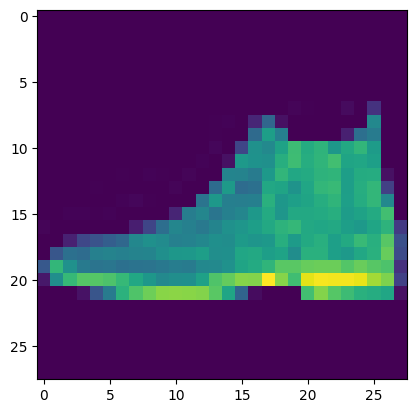

PREDICTION: 9


In [33]:
def main():
  mnist_test_images, test_data_loader, mnist_transforms = get_fashion_mnist_test_data()

  test_model = get_jaewoo_cnn_model()
  classification_tester = ClassificationTester(
    "mnist", test_model, test_data_loader, mnist_transforms, CHECKPOINT_FILE_PATH
  )
  classification_tester.test()

  print()

  img, label = mnist_test_images[0]
  print("     LABEL:", label)

  plt.imshow(img)
  plt.show()

  # torch.tensor(np.array(mnist_test_images[0][0])).unsqueeze(dim=0).unsqueeze(dim=0).shape: (1, 1, 28, 28)
  output = classification_tester.test_single(
    torch.tensor(np.array(mnist_test_images[0][0])).unsqueeze(dim=0).unsqueeze(dim=0)
  )
  print("PREDICTION:", output)


if __name__ == "__main__":
  main()


# 🚀 Test Accuracy: 92.85%

# 👨🏻‍💻 테스트 결과 고찰


내가 훈련한 모델로 테스트를 진행한 결과 정확도 92.85%에 해당하는 결과를 얻었다.


테스트에 사용한 이미지는 Ankle boot이며 레이블은 9이다.

테스트 결과 Prediction = 9로 레이블과 동일한 것을 확인할 수 있다.

모델을 수없이 훈련만 하다가 테스트 결과를 보니 마음이 후련하고 기분이 정말 좋다😎

# [문제4] 샘플 테스트 데이터 분류 예측 결과 확인하기

- 10,000개의 테스트 데이터 중 10개를 임의로 선택하여
  - 1) 해당 이미지를 출력하고
  - 2) 해당 이미지의 레이블을 출력하고
  - 3) 학습 완료된 모델을 사용하여 해당 이미지의 분류 예측 결과를 출력하여
  - 4) 이미지 레이블과 분류 예측 결과가 동일한지 점검

  
    

Num Test Samples:  10000
Sample Shape:  torch.Size([1, 28, 28])
in 1 out 10
MODEL FILE: /content/checkpoints/fashion_mnist_hw3_checkpoint_latest.pt
TEST RESULTS: 92.850%



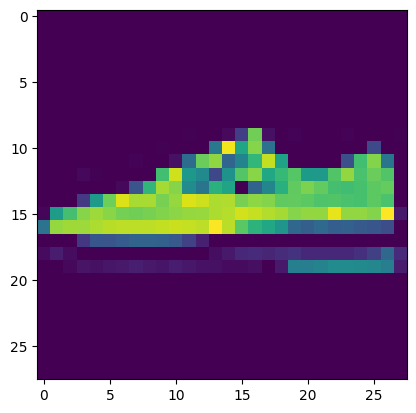

========= RESULT ========
     LABEL: 7
PREDICTION: 7
🎉 SUCCESS PREDICTION



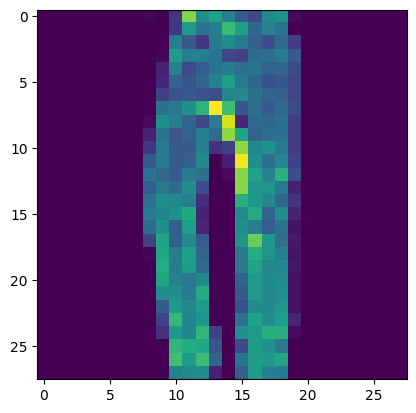

========= RESULT ========
     LABEL: 1
PREDICTION: 1
🎉 SUCCESS PREDICTION



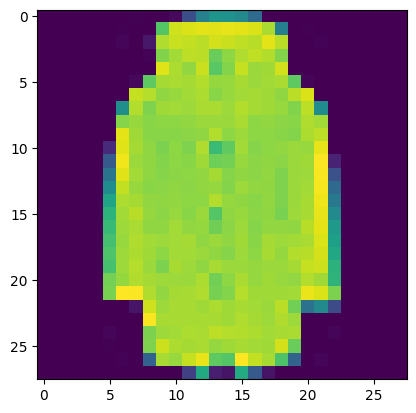

========= RESULT ========
     LABEL: 4
PREDICTION: 4
🎉 SUCCESS PREDICTION



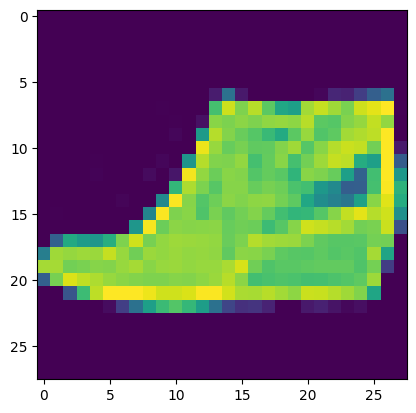

========= RESULT ========
     LABEL: 9
PREDICTION: 9
🎉 SUCCESS PREDICTION



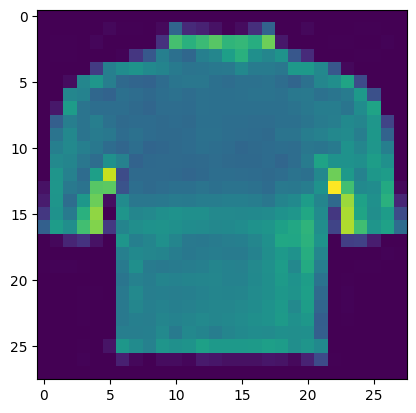

========= RESULT ========
     LABEL: 6
PREDICTION: 0
❌ FAILURE PREDICTION



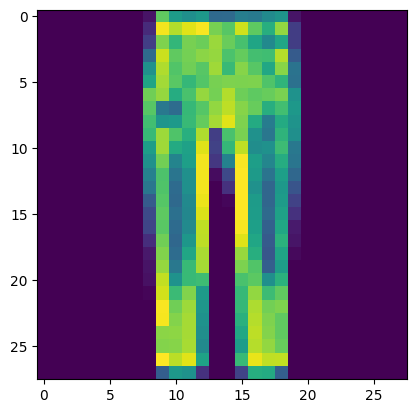

========= RESULT ========
     LABEL: 1
PREDICTION: 1
🎉 SUCCESS PREDICTION



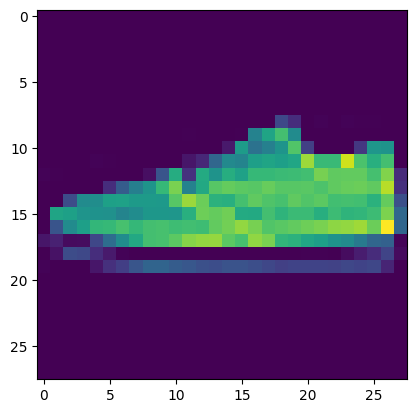

========= RESULT ========
     LABEL: 7
PREDICTION: 7
🎉 SUCCESS PREDICTION



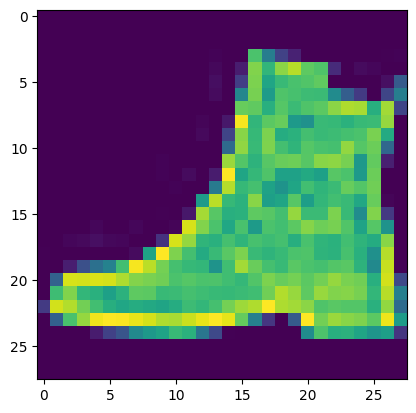

========= RESULT ========
     LABEL: 9
PREDICTION: 9
🎉 SUCCESS PREDICTION



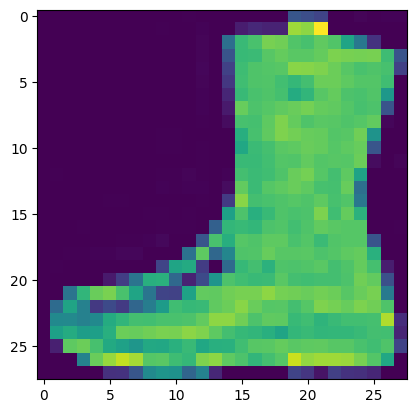

========= RESULT ========
     LABEL: 9
PREDICTION: 9
🎉 SUCCESS PREDICTION



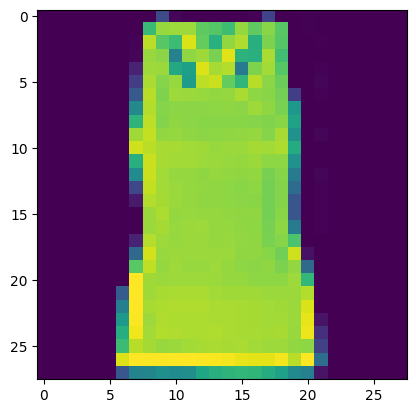

========= RESULT ========
     LABEL: 0
PREDICTION: 0
🎉 SUCCESS PREDICTION



In [32]:
def main():
  mnist_test_images, test_data_loader, mnist_transforms = get_fashion_mnist_test_data()

  test_model = get_jaewoo_cnn_model()
  classification_tester = ClassificationTester(
    "mnist", test_model, test_data_loader, mnist_transforms, CHECKPOINT_FILE_PATH
  )
  classification_tester.test()

  print()

  for idx in select_random_values(10, 10000):
    img, label = mnist_test_images[idx]


    plt.imshow(img)
    plt.show()

    # torch.tensor(np.array(mnist_test_images[0][0])).unsqueeze(dim=0).unsqueeze(dim=0).shape: (1, 1, 28, 28)
    output = classification_tester.test_single(
      torch.tensor(np.array(mnist_test_images[idx][0])).unsqueeze(dim=0).unsqueeze(dim=0)
    )


    print("========= RESULT ========")

    print("     LABEL:", label)
    print("PREDICTION:", output)
    if label == output:
      print("🎉 SUCCESS PREDICTION")

    else:
      print("❌ FAILURE PREDICTION")

    print("=========================")
    print()
if __name__ == "__main__":
  main()


# 👨🏻‍💻 6번 레이블 이미지 예측 실패에 대한 해석

학습시킨 모델로 예측 결과를 얻어봤는데 대부분의 경우 10,000개 데이터 중 10개를 뽑아도 10번 모두 예측 결과를 올바르게 내 놓았다.

그러다가 간혹 1개 정도 레이블에 대해 예측 실패한 경우가 있었다.

그 경우가 위의 6번 레이블 이미지에 대해 0번 레이블로 예측한 것이다.

모델이 잘못 예측한 0번 레이블 데이터는 T-shirt/top이며,
정답인 6번 레이블 데이터는 Shirt이다.

그렇다면 모델은 Shirt 이미지에 대해 어떠한 이유로 T-shirt/top으로 해석한 것인데,

이미지의 특징에서 보아 Shirt와 T-shirt가 전체적으로 외형이 비슷하게 생겼다고 생각한다.

실제로 Fashion_mnist_data를 확인해보았을 때 전반적으로 옷의 외형이 비슷하다.

그렇지만 이런 해석은 그냥 나의 느낌일 뿐이고 딥러닝의 모델 관점에서 보자면,

CNN을 통해 이미지의 특징들을 추출했을 때 6번 레이블(Shirt)로 입력된 이미지에서 0번 레이블(T-shirt/top)이미지에 대한 특징을 상당수 발견했기에 6번 레이블 이미지에 대해 0번 레이블로 잘못된 예측을 했다고 생각한다.

6번 레이블(Shirt)에 대해 추출한 특징 중 카라, 옷의 너비 같은 부분이 0번 레이블(T-shirt/top)에서 추출한 특징과 비슷하게 인식되었기 때문이 아닐까 싶다.

옷에 대해 잘 아는 사람이 두 개의 이미지를 보고 바로 판단할 수 있는 것은 그동안의 경험(티셔츠는 어떤 특징이 있고, 셔츠는 또 어떤 특징이 있고)에 따라 인간의 **"느낌"**으로 판단하는 것이다.

학습 시킨 딥러닝 모델이 이미지의 특징들을 보고 판단하는 것에서 인간의 느낌으로 판단하는 것과 유사하다고 생각했다.




# 👨🏻‍💻 전반적인 과제 고찰 및 숙제 후기

마침내 3번째 딥러닝및실습 과제까지 해결했다.

내가 여태 만났던 그 어떤 과제보다 힘듦을 매 과제마다 느끼고 있다.

그치만 그만큼 얻어가는 것도 많다고 생각한다.

이번 과제에서는 그동안 배웠던 CNN 모델과 최적화 기법을 활용하여 Fashion mnist 데이터로 딥러닝 모델을 훈련시키고 예측 결과를 확인해보는 과제였다.

이번 과제는 훈련 과정 + 정확도를 높이기 위한 갖은 최적화 + 분류 예측 결과까지 딥러닝 전반의 프로세스를 공부하고 실습해볼 수 있었던 너무 귀중한 경험으로 남을 것이다.

기억에 남는 순간이 많은데, 이전까지는 교수님께서 모델 훈련시키는데 데이터 양이 많으면 우리들 PC에서는 할 수 없고 좋은 컴퓨팅 자원을 가진 환경에서도 엄청 오래 걸린다고 하신 말씀에 반신반의했다.

내 공부 수준과 환경에서 이전까지 그렇게 오래 걸리는 작업을 해본적이 없었으며,

컴퓨터가 1초에 1억번의 연산을 하는데 그렇게 오래 걸리는게 말이 되나 싶었다.

그러나 이번에 모델을 훈련시키면서 정말 큰 데이터에 대해서는 엄청나게 오래걸릴 수 있겠구나 싶었다.

fashion mnist 데이터에 모델의 채널을 늘리고 레이어를 깊게 하였을 때는 훈련 속도가 정말 달팽이가 기어가는 듯했다.

정말 괴롭다는 말이 딱 와 닿았다.

그래서 좋은 컴퓨터 자원이 절실히 필요함을 깨달았다.

두번째로는 Validation accuracy를 높이기 위한 갖은 노력이다.

정말 이 1%를 위해 하이퍼파라미터를 땡겼다 밀었다 조절해보고 최적화 기법을 넣어보고 또, 모델의 레이어를 더 깊게하거나 채널의 수를 늘려보는등 정말 많은 시도를 했다.

그러면서 느낀 것은 모델의 레이어를 깊게하고 채널의 수를 늘리면 학습 파라미터가 많아지면서 좋은 학습 과정과 높은 정확도를 기대할 수 있겠지만, 그와 함께 긴 학습 시간을 기다려야 하는 것이다.

결국 모든 공학이 그렇듯이 딥러닝에서도 trade-off에 부딪힐 수 밖에 없는 것이다.

그럼에도 불구하고 더 높은 정확도와 최선의 학습 시간을 찾는 것이 이 분야의 중요한 일이지 않을까 생각한다.

그리고 그러한 최적점을 찾았을 때 딥러닝을 공부하는 데에 자부심을 느낄만한 것 같다.





